Spdl oscillations analysis...
1314 Total neurons in the cross-registration
4364 Spdl recorded in total
Spdl_CaPSTH_baseline
Spdl_CaPSTH_UnCoupledbaseline
Spdl_CaPSTH_PreCoupledbaseline
Spdl_CaPSTH_PostCoupledbaseline
Spdl_CaPSTH_PrePostCoupledbaseline
Spdl_CaPSTH_S1baseline
Spdl_CaPSTH_UnCoupledS1baseline
Spdl_CaPSTH_PreCoupledS1baseline
Spdl_CaPSTH_PostCoupledS1baseline
Spdl_CaPSTH_PrePostCoupledS1baseline
Spdl_CaPSTH_PFCbaseline
Spdl_CaPSTH_UnCoupledPFCbaseline
Spdl_CaPSTH_PreCoupledPFCbaseline
Spdl_CaPSTH_PostCoupledPFCbaseline
Spdl_CaPSTH_PrePostCoupledPFCbaseline
Spdl_CaPSTH_S1PFCbaseline
Spdl_CaPSTH_UnCoupledS1PFCbaseline
Spdl_CaPSTH_PreCoupledS1PFCbaseline
Spdl_CaPSTH_PostCoupledS1PFCbaseline
Spdl_CaPSTH_PrePostCoupledS1PFCbaseline
Spdl_CaPSTH_CGP
Spdl_CaPSTH_UnCoupledCGP
Spdl_CaPSTH_PreCoupledCGP
Spdl_CaPSTH_PostCoupledCGP
Spdl_CaPSTH_PrePostCoupledCGP
Spdl_CaPSTH_S1CGP
Spdl_CaPSTH_UnCoupledS1CGP
Spdl_CaPSTH_PreCoupledS1CGP
Spdl_CaPSTH_PostCoupledS1CGP
Spdl_CaPSTH_PrePostCouple

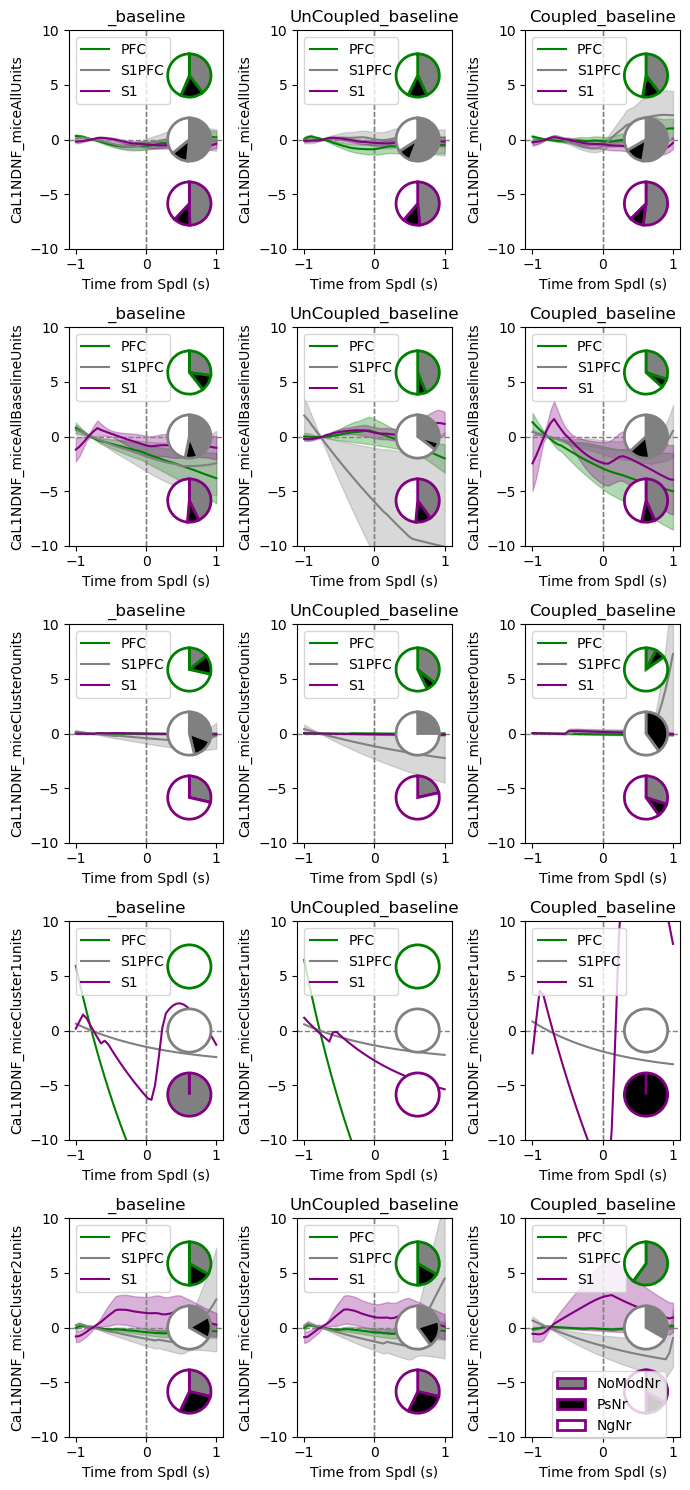

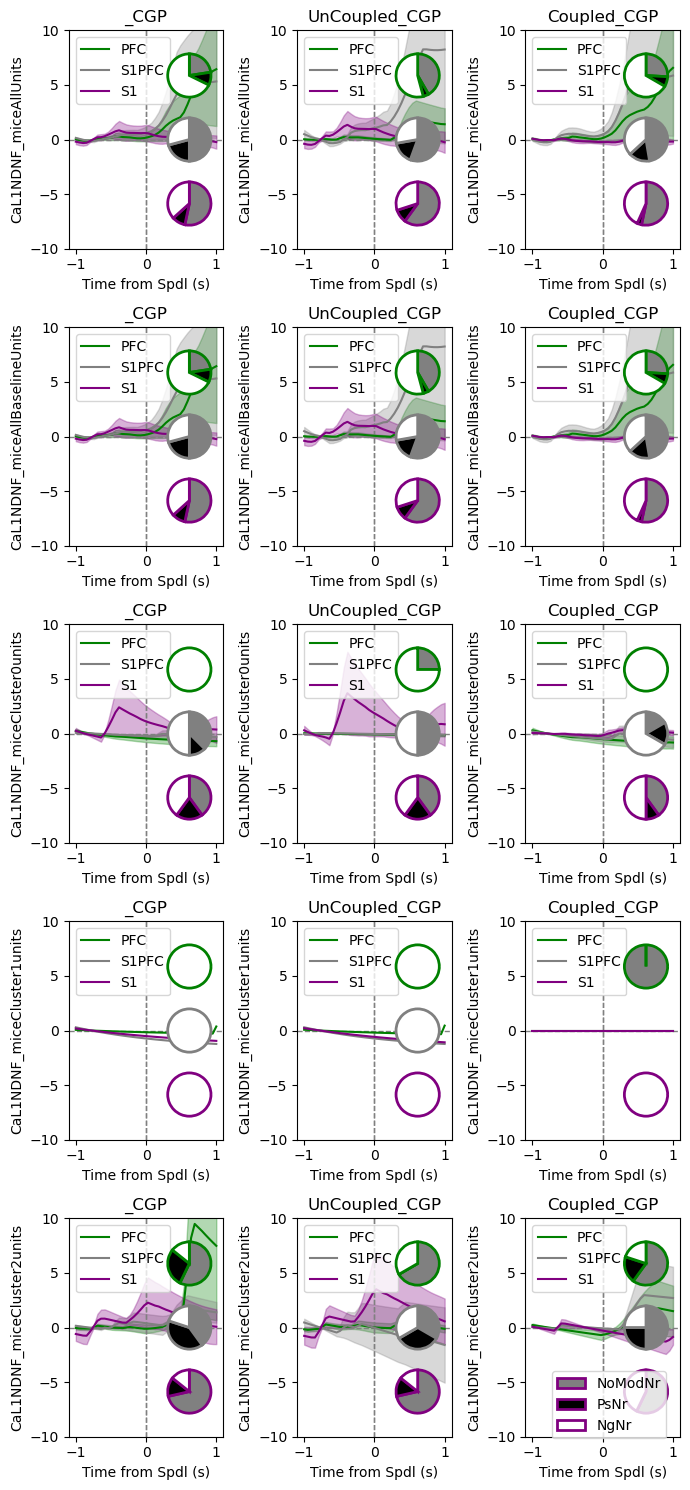

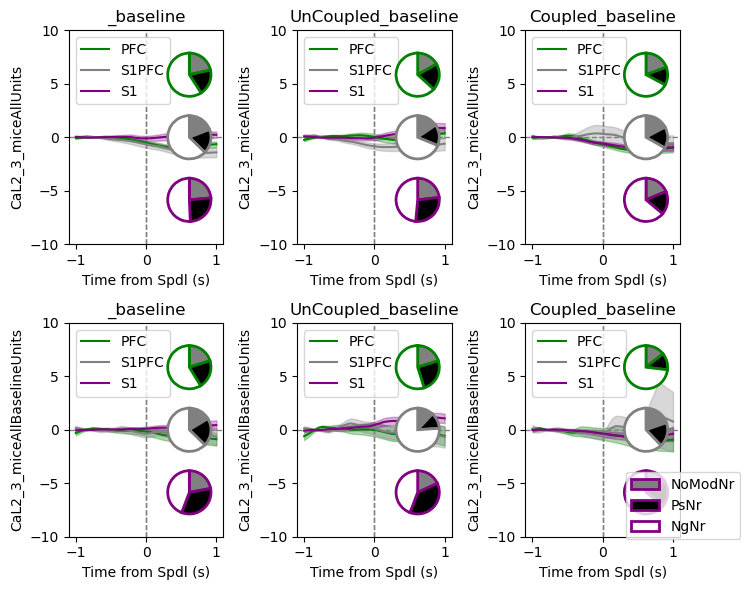

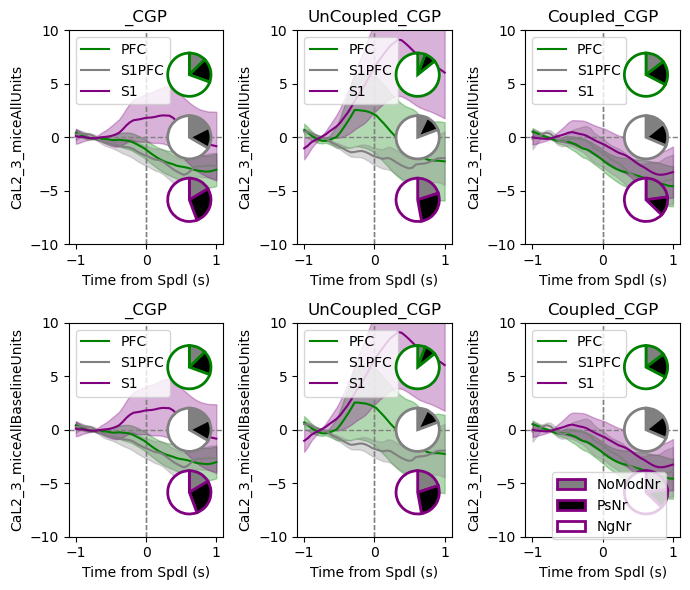

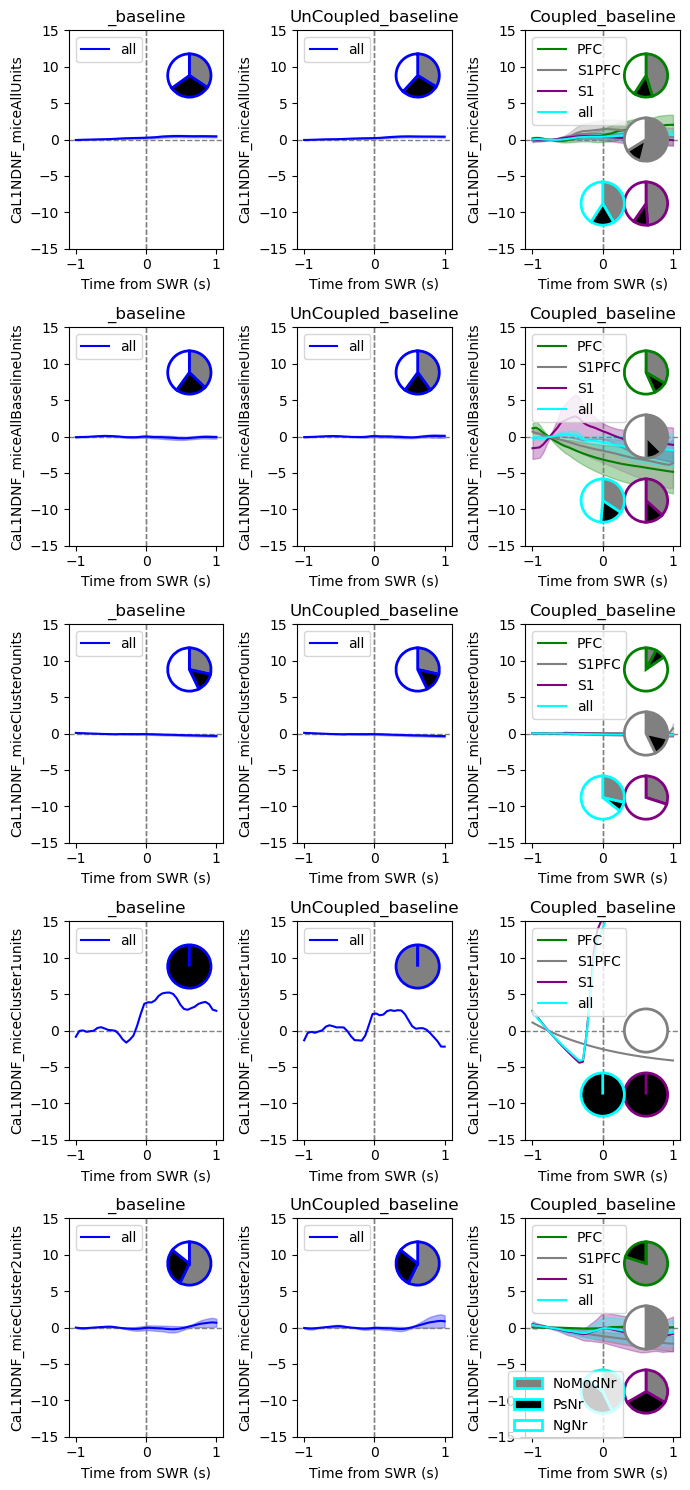

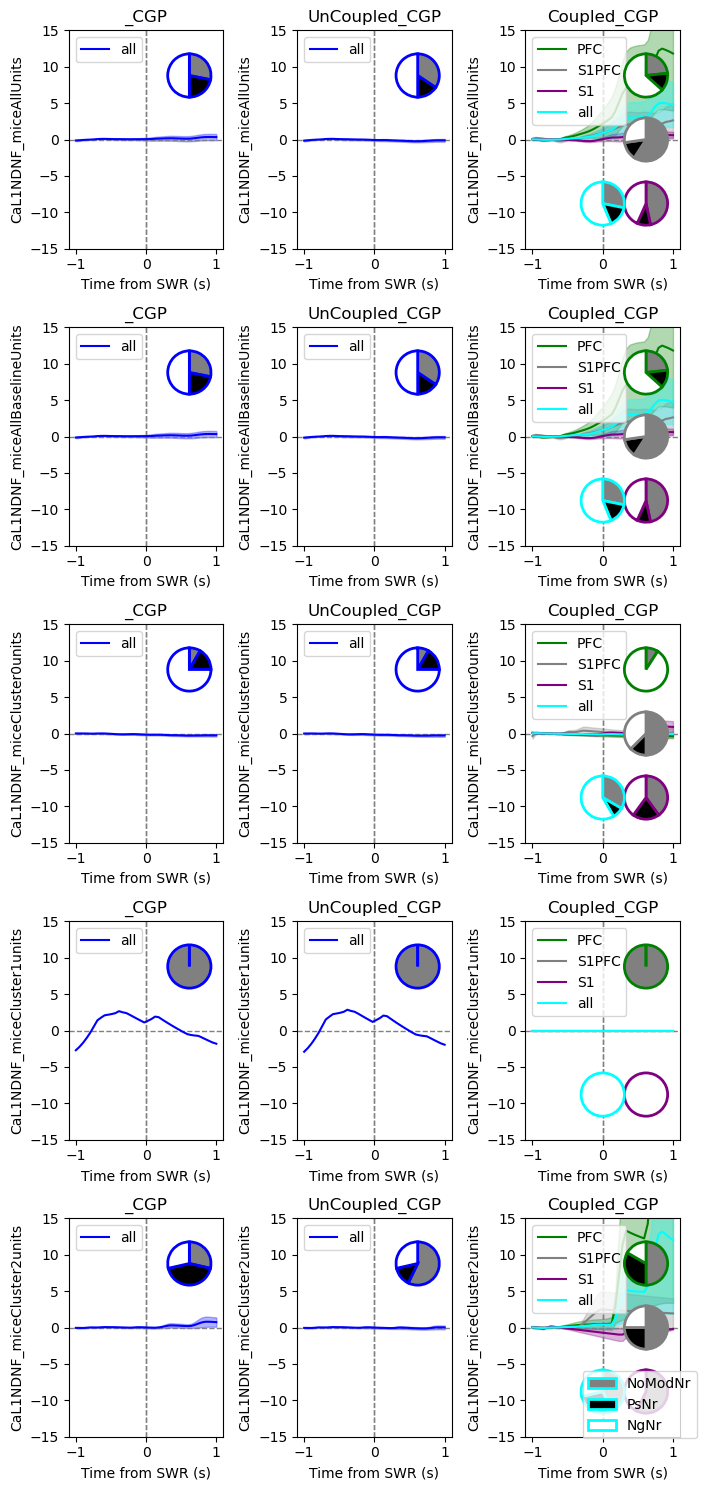

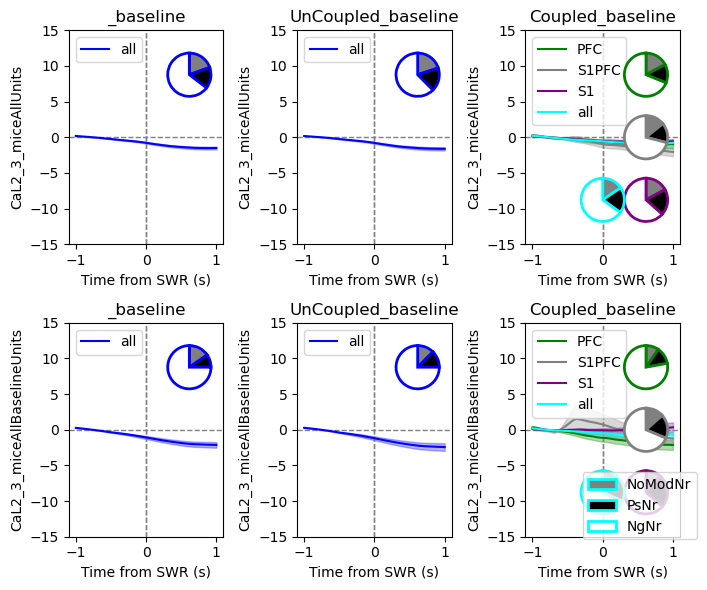

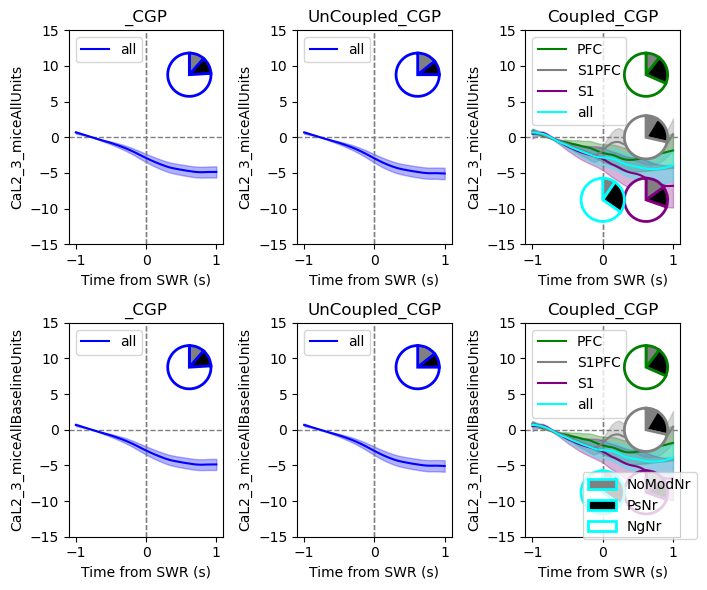

In [ ]:
# Stats on Ca2+ imaging with miniscope and Osc
#######################################################################################
                            # Define Experiment type #
#######################################################################################

DrugExperiment=0 # 1 if CGP Experiment, 0 if Baseline Experiment

AnalysisID='PERMUTED_baseline' 

choosed_folder='Osc_2025-06-02_16_05_08_PERMUTED_pynapple'
choosed_folder2='VigSt_2025-05-21_15_47_42_CGP'

Local=1
#######################################################################################
                                # Load packages #
#######################################################################################

import statsmodels.api as sm
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import pickle
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import zscore
from scipy.stats import sem
from datetime import datetime
import shutil
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

warnings.filterwarnings("ignore")


def column_with_max_single_per_row(row):
    max_val = row.max()  # Find the max value in the row
    max_columns = row == max_val  # Boolean Series of columns with max value
    
    if max_columns.sum() > 1:
        return 'NoPref'  # More than one column has the max value
    else:
        return max_columns.idxmax()  # Return the name of the column with max value

def divide_keys(data):
    it=list(data.keys())[0]
    d=data[it]
    data[it]=d.replace(0, np.nan)
    for sheet in list(data.keys())[1:]: 
        data[sheet].div(data[it][sheet], axis=0)
    del data[it]
    return data    

########################################################################
                            # Define Directories #
########################################################################

# Specify the directory containing the Excel files
InitialDirectory1 = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_baseline_analysis" if Local else "/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_baseline_analysis" 
directory1= f'{InitialDirectory1}/{choosed_folder}'
InitialDirectory2 ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_CGP_analysis" if Local else "/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_CGP_analysis"
directory2= f'{InitialDirectory2}/{choosed_folder}'


InitialDirectorY = InitialDirectory2#InitialDirectory1 if DrugExperiment==0 else InitialDirectory2
directory3= f'{InitialDirectorY}/{choosed_folder2}'

# Get the current date and time
FolderNameSave=str(datetime.now())[:19]
FolderNameSave = FolderNameSave.replace(" ", "_").replace(".", "_").replace(":", "_")
destination_folder= f"//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_global_analysis/AVG_Osc_{FolderNameSave}{AnalysisID}" if Local else f"/crnldata/waking/audrey_hay/L1imaging/Analysed2025_AB/_global_analysis/AVG_Osc_{FolderNameSave}{AnalysisID}"
os.makedirs(destination_folder)
folder_to_save=Path(destination_folder)

# Copy the script file to the destination folder
source_script = "C:/Users/Manip2/SCRIPTS/CodePythonAudrey/CodePythonAurelie/HayLabAnalysis/python/_MINI&OE_7_average_osc_per_cluster.ipynb" if Local else "/python/_MINI&OE_7_average_osc_per_cluster.ipynb" 
destination_file_path = f"{destination_folder}/_MINI&OE_7_average_osc_per_cluster.txt"
shutil.copy(source_script, destination_file_path)


#######################################################################################
                            # Do the average per cluster #
#######################################################################################

CTX=['', 'S1', 'PFC', 'S1PFC']
CouplingO=['', 'UnCoupled', 'PreCoupled', 'PostCoupled', 'PrePostCoupled']
Coupling1=['', 'UnCoupled', 'Coupled', 'Coupled', 'Coupled']
Coupling=['', 'UnCoupled', 'Coupled']
OscList=['Spdl', 'SWR']
Drugs= ['baseline', 'CGP'] if DrugExperiment else ['baseline']

NrSubtypeList=['L1NDNF_mice','L2_3_mice']


# Load Global Table 
with open(f'{directory3}/VigStates_Global_cluster.pkl', 'rb') as pickle_file:
    Vig_cluster_dfO = pickle.load(pickle_file)

for o, Osc in enumerate(OscList): 
    
    print(Osc, 'oscillations analysis...')

    AllOscStatut=pd.DataFrame()
    AllOscDuration=pd.DataFrame()
    AllOscDuration2=pd.DataFrame()
    AllGlobalSpindle=pd.DataFrame()
    AllOscStartLocation=pd.DataFrame()
    AllOscSWRinside=pd.DataFrame()
    AllOscCoupling=pd.DataFrame()

                
    # Initialize an empty list to store the dataframes
    combined_df = []
    filtered_df=[]

    ###########################################################################
                                ##### GLOBAL #####
    ###########################################################################

    # Load Global Table 
    directorY= directory2#directory1 if DrugExperiment==0 else directory2
    with open(f'{directorY}/{Osc}_Global.pkl', 'rb') as pickle_file:
        combined_df = pickle.load(pickle_file)

    combined_df['Unique_Unit'] = combined_df['Unique_Unit'].astype(str)
    combined_df['UnitNumber'] = combined_df['UnitNumber'].astype(str)
    combined_df['UnitValue'] = combined_df['UnitValue'].astype(str)

    combined_df[f'{Osc}Statut'] = combined_df[f'{Osc}Statut'].astype(str)

    combined_df['Unit_ID'] = combined_df['Mice'] + combined_df['Unique_Unit']
    combined_df['Session_ID'] = combined_df['Mice'] + '_' + combined_df['Session_Date'] + '_' + combined_df['Session_Time']

    unique_count = combined_df['Unit_ID'].nunique()
    print(unique_count, f'Total neurons in the cross-registration') 
    
    combined_df[f'{Osc}_ID'] = combined_df['Mice'] + '_' + combined_df['Session_Date'] + '_' + combined_df['Session_Time'] + '_' +combined_df[f'{Osc}Number'].astype(str)
    
    unique_count = combined_df[f'{Osc}_ID'].nunique()
    print(unique_count, f'{Osc} recorded in total')

    Vig_cluster_dfO['Unit_ID'] = Vig_cluster_dfO['Mice'] + Vig_cluster_dfO['Unique_Unit']
    merged = pd.merge(combined_df, Vig_cluster_dfO[['ClusterHDBSCAN', 'Unit_ID']].drop_duplicates(), on='Unit_ID', how='outer')

    writer = pd.ExcelWriter(f'{folder_to_save}/{Osc}_Global.xlsx')
    merged.to_excel(writer)
    writer.close()
    
    ###########################################################################
                                ##### GLOBAL #####
    ###########################################################################

    for NrSubtype in NrSubtypeList: 

        if NrSubtype=='L1NDNF_mice':
            MiceList=['BlackLines', 'BlueLines', 'GreenDots', 'GreenLines', 'RedLines']
        else:
            MiceList=['PurpleSquare', 'ThreeColDots', 'ThreeBlueCrosses']

        Data=['Ca', 'Sp']
        for data in Data:
            for drug in Drugs: 
                for ctx in CTX:
                    locals()[f'{data}PSTH{Osc}_{ctx}{drug}']={}
                    locals()[f'{data}PSTH{Osc}_UnCoupled{ctx}{drug}']={}
                    locals()[f'{data}PSTH{Osc}_Coupled{ctx}{drug}']={}
                    
                    for ci, coup in enumerate(CouplingO):  
                        coup2= Coupling1[ci]            
                        dfsPSTH_per_sheet = locals()[f'{data}PSTH{Osc}_{coup2}{ctx}{drug}']
                        nametofind2=f'{Osc}_{data}PSTH_{coup}{ctx}{drug}'
                        print(nametofind2)
                        # Recursively traverse the directory structure
                        for directory in [directorY]:
                            for root, _, files in os.walk(directory):
                                for filename in files:
                                    if filename.endswith('.pkl') and nametofind2 in filename: 
                                        if any(name in filename for name in MiceList): 
                                            # Construct the full path to the file
                                            filepath = os.path.join(root, filename)
                                            with open(filepath, 'rb') as pickle_file:
                                                df = pickle.load(pickle_file)
                                            for key, value in df.items():
                                                if key in dfsPSTH_per_sheet:
                                                    dfsPSTH_per_sheet[key]=pd.concat([pd.DataFrame(dfsPSTH_per_sheet[key]),pd.DataFrame(value)], ignore_index=False, axis=0)
                                                else:
                                                    dfsPSTH_per_sheet[key]=pd.DataFrame(value)


        ###########################################################################
                                ##### PREFERENCE #####
        ###########################################################################
        
        print(NrSubtype, '...') 
        
        Vig_cluster_df = Vig_cluster_dfO.copy()
        Vig_cluster_df = Vig_cluster_df[Vig_cluster_df['NeuronType'] == NrSubtype]
        Vig_cluster_df_Drug = Vig_cluster_df.copy()   
        Vig_cluster_df_Drug = Vig_cluster_df_Drug[Vig_cluster_df_Drug['Drug'] == 'baseline']     
        AllUnits = Vig_cluster_df_Drug['Unit_ID'].unique()  

        Cluster0units = Vig_cluster_df_Drug[Vig_cluster_df_Drug['ClusterHDBSCAN'] == 0]['Unit_ID'].unique()
        Cluster1units = Vig_cluster_df_Drug[Vig_cluster_df_Drug['ClusterHDBSCAN'] == 1]['Unit_ID'].unique()
        Cluster2units = Vig_cluster_df_Drug[Vig_cluster_df_Drug['ClusterHDBSCAN'] == 2]['Unit_ID'].unique()
        
        # Only keep units that appears in CGP & Baseline    
        if DrugExperiment>=1 :
            Vig_cluster_df_Drug_CGP=Vig_cluster_df.copy()
            Vig_cluster_df_Drug_CGP = Vig_cluster_df_Drug_CGP[Vig_cluster_df_Drug_CGP['Drug'] == 'CGP'] 
            AllCGPUnits = Vig_cluster_df_Drug_CGP['Unit_ID'].unique()

            AllBaselineUnits= np.intersect1d(AllUnits,AllCGPUnits)
            Cluster0units= np.intersect1d(Cluster0units,AllBaselineUnits)
            Cluster1units= np.intersect1d(Cluster1units,AllBaselineUnits)
            Cluster2units= np.intersect1d(Cluster2units,AllBaselineUnits)
 
        for drug in Drugs: 
            
            combined_df_Drug = combined_df.copy()
            try:
                combined_df_Drug = combined_df_Drug[combined_df_Drug['Drug'] == drug]
            except: 
                combined_df_Drug=combined_df_Drug
            
            folder_to_save2= f'{folder_to_save}/{drug}/'
            if NrSubtype=='L1NDNF_mice' and o==0 :
                os.makedirs(folder_to_save2)  

            if DrugExperiment==1:
                listCluster=['AllUnits', 'AllBaselineUnits', 'Cluster0units', 'Cluster1units', 'Cluster2units'] if NrSubtype=='L1NDNF_mice' else ['AllUnits', 'AllBaselineUnits']
            else:
                listCluster=['AllUnits', 'Cluster0units', 'Cluster1units', 'Cluster2units'] if NrSubtype=='L1NDNF_mice' else ['AllUnits']

            NbNr=pd.DataFrame()  
            
            fig0, axes0 = plt.subplots(len(listCluster), len(Coupling), figsize=(7, 3*len(listCluster)))      
            axes0 = axes0.flatten() 
            ii=0

            # Print the names of the sheets and their corresponding DataFrames
            for l,List_name in enumerate(listCluster):
                
                thelist=locals()[f'{List_name}']
                filtered_df = combined_df_Drug[combined_df_Drug['Unit_ID'].isin(thelist)]
                GroupList=['AllUnits', 'SignMod', 'NoModNr', 'PsNr', 'NgNr']

                if NrSubtype=='L1NDNF_mice' :#and o==0:
                    new_folder= f"{folder_to_save2}/{List_name}/{Osc}/"
                    os.makedirs(new_folder)

                ###########################################################################
                                        ##### AVERAGE PSTH #####
                ###########################################################################

                for coup in Coupling:
                    filenameOutAVG = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_{coup}AVG&SEM.xlsx'
                    locals()[f'excel_writerAVG{coup}']= pd.ExcelWriter(filenameOutAVG)

                    filenameOutMean = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_{coup}During.xlsx'
                    locals()[f'excel_writerMean{coup}']= pd.ExcelWriter(filenameOutMean)

                    """
                    filenameOutMean = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_{coup}Baseline.xlsx'
                    locals()[f'excel_writerMeanBase{coup}']= pd.ExcelWriter(filenameOutMean)

                    filenameOutMean = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_{coup}Before.xlsx'
                    locals()[f'excel_writerMeanBef{coup}']= pd.ExcelWriter(filenameOutMean)

                    filenameOutMean = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_{coup}AllBefore.xlsx'
                    locals()[f'excel_writerMeanAllBef{coup}']= pd.ExcelWriter(filenameOutMean)

                    filenameOutMean = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_{coup}PSTH.xlsx'
                    locals()[f'excel_writer{coup}']= pd.ExcelWriter(filenameOutMean)
                    """
                
                for data in Data:
                    
                    if data=='Ca':
                        filenameOutPN = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_NrProportion.xlsx'
                        excel_writerPN= pd.ExcelWriter(filenameOutPN)                 
                                   

                    for cp, coup in enumerate(Coupling):                         

                        BigArray=pd.DataFrame()
                        BigArrayBSL=pd.DataFrame()
                        AVGArray=pd.DataFrame()
                        AVGArrayBSL=pd.DataFrame()
                        AVGArraybefore=pd.DataFrame()
                        AVGArrayallbefore=pd.DataFrame()
                        AVGArrayBSLbefore=pd.DataFrame()
                        AVGArrayBSLallbefore=pd.DataFrame()
                        AVGArraybaseline=pd.DataFrame()
                        AVGArrayBSLbaseline=pd.DataFrame()
                        
                        for ctx in CTX:
                            
                            if f'{data}PSTH{Osc}_{coup}{ctx}{drug}' in locals(): #cause no ctx if uncoupled

                                df_per_sheet=locals()[f'{data}PSTH{Osc}_{coup}{ctx}{drug}']

                                #filenameOut = f'{folder_to_save2}/{List_name}/{Osc}/{NrSubtype}_{data}PSTH_{coup}{ctx}_{drug}.pkl' #keep each responses of each cells for all rec Osc
                                #with open(filenameOut, 'wb') as pickle_file:
                                #    pickle.dump(df_per_sheet, pickle_file)

                                if len(df_per_sheet.keys()): # not empty

                                    # if PSTH is full lenght
                                    arrayLen = 0
                                    for key, value in df_per_sheet.items():
                                        if value.size > 0:
                                            arrayLen = np.shape(value)[1]
                                            break  
                                    # if PSTH is 2 sec lenght    
                                    arrayLen=40
                                    
                                    for group in GroupList:
                                        locals()[f'{group}Array']=pd.DataFrame(columns=np.arange(0,arrayLen,1))
                                    
                                    for nr in df_per_sheet.keys():
                                        #print(nr, '=', df_per_sheet[nr].shape[0], ctx,  Osc, coup, 'recorded') # print the neuron ID
                                    
                                        if df_per_sheet[nr].shape[0] >= 3 : # at least 10 oscillations recorded

                                            if df_per_sheet[nr].shape[1] != 40:
                                                print('/!/ Issue with the length of the PSTH !')
                                                break
                                            
                                            #if arrayLen==40: # All Osc at 1 second 
                                            #    if Osc== 'Spdl':
                                            #        PSTH=df_per_sheet[nr].iloc[:, df_per_sheet[nr].shape[1] // 10 *4  : df_per_sheet[nr].shape[1] // 10 * 6] # -1 to 1 sec for Spdl (-5 to 5s)
                                            #    else:
                                            #        PSTH=df_per_sheet[nr].iloc[:, df_per_sheet[nr].shape[1] // 6 *2  : df_per_sheet[nr].shape[1] // 6 * 4] # -1 to 1 sec for SWR & DS (-3 to 3s)
                                            
                                            PSTH=df_per_sheet[nr]

                                            AVGtrace=np.nanmean(PSTH, axis=0)
                                            
                                            BaselineSTD=np.std(AVGtrace[:PSTH.shape[1]//4], axis=0)

                                            upperThrs=np.nanmean(AVGtrace[:PSTH.shape[1]//4], axis=0) + BaselineSTD*2
                                            lowerThrs=np.nanmean(AVGtrace[:PSTH.shape[1]//4], axis=0) - BaselineSTD*2

                                            AVGbefore=np.nanmean(AVGtrace[PSTH.shape[1]//4:PSTH.shape[1]//4*2], axis=0)
                                            AVGafter=np.nanmean(AVGtrace[PSTH.shape[1]//4*2:PSTH.shape[1]//4*4], axis=0)
                                            AVGearly=np.nanmean(AVGtrace[PSTH.shape[1]//4*2:PSTH.shape[1]//4*3], axis=0)
                                            AVGlate=np.nanmean(AVGtrace[PSTH.shape[1]//4*3:PSTH.shape[1]//4*4], axis=0)
                                            
                                            if AVGafter > upperThrs:
                                                group='PsNr'
                                                Array=locals()[f'SignModArray']
                                                Array.loc[nr]=AVGtrace
                                            elif AVGafter < lowerThrs:
                                                group='NgNr'
                                                Array=locals()[f'SignModArray']
                                                Array.loc[nr]=AVGtrace
                                            else: 
                                                group='NoModNr'
                                            
                                            Array=locals()[f'{group}Array']
                                            Array.loc[nr]=AVGtrace
                                            Array=locals()[f'AllUnitsArray']
                                            Array.loc[nr]=AVGtrace

                                    for group in GroupList:

                                        ArrayO=locals()[f'{group}Array']

                                        if not ArrayO.isna().all().all():

                                            # Only keep the neurons belonging to the list (All units, NREM active, REM active, etc)
                                            present_indices = [idx for idx in thelist if idx in ArrayO.index]
                                            Array = ArrayO.loc[present_indices] 

                                            n=Array.shape[0]
                                            NbNr.loc[group,f'{ctx}{coup}']=n

                                            # Leave a blanck space for units not recorded in that condition
                                            missing_indexes = set(thelist) - set(Array.index)
                                            Array = Array.reindex(Array.index.union(missing_indexes))
                                            Array = Array.sort_index()

                                            ArrayO=Array.copy()
                                            mArray=Array.mean(axis=0)
                                            semArray = stats.sem(Array, axis=0, ddof=1, nan_policy='omit')
                                            icArray = norm.ppf((1 +  0.95) / 2) * (np.std(Array, axis=0) / np.sqrt(Array.shape[0]))
                                            #SmallArray=pd.DataFrame(np.transpose([mArray,semArray,icArray]), columns=[f'{ctx}{coup}{Osc} Mean', f'{ctx}{coup}{Osc} SEM', f'{ctx}{coup}{Osc} IC'])
                                            SmallArray=pd.DataFrame(np.transpose([mArray,semArray]), columns=[f'{group}{ctx}mean', f'{group}{ctx}sem'])
                                        
                                            BigArray=pd.concat([BigArray,SmallArray], axis=1)

                                            SecondHalf_columns = Array.iloc[:, Array.shape[1] //2:]
                                            mean_baseline = SecondHalf_columns.mean(axis=1)
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArray=pd.concat([AVGArray,avgarray], axis=1)

                                            FirstQuarter_columns = Array.iloc[:, :Array.shape[1] //4]
                                            mean_baseline = FirstQuarter_columns.mean(axis=1)
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArraybaseline=pd.concat([AVGArraybaseline,avgarray], axis=1)

                                            SecondQuarter_columns = Array.iloc[:, Array.shape[1]//4:Array.shape[1]//4*2]
                                            mean_baseline = SecondQuarter_columns.mean(axis=1)
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArraybefore=pd.concat([AVGArraybefore,avgarray], axis=1)

                                            FirstHalf_columns = Array.iloc[:, :Array.shape[1]//2]
                                            mean_baseline = FirstHalf_columns.mean(axis=1)
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArrayallbefore=pd.concat([AVGArrayallbefore,avgarray], axis=1)
                                            
                                            # Baseline signals
                                            baseline_columns = Array.iloc[:, :Array.shape[1] // 4]
                                            mean_baseline = baseline_columns.mean(axis=1)
                                            Array = Array.sub(mean_baseline, axis=0)
                                        
                                            #excel_writer=locals()[f'excel_writer{coup}']
                                            #Array.to_excel(excel_writer, sheet_name=f'{data}BSL_{group}{ctx}', index=True, header=False)
                                            #ArrayO.to_excel(excel_writer, sheet_name=f'{data}{group}{ctx}', index=True, header=False)

                                            mArray=Array.mean(axis=0)
                                            semArray = stats.sem(Array, axis=0, ddof=1, nan_policy='omit')
                                            icArray = norm.ppf((1 +  0.95) / 2) * (np.std(Array, axis=0) / np.sqrt(Array.shape[0]))
                                            #SmallArray=pd.DataFrame(np.transpose([mArray,semArray,icArray]), columns=[f'{ctx}{coup}{Osc} Mean', f'{ctx}{coup}{Osc} SEM', f'{ctx}{coup}{Osc} IC'])
                                            SmallArray=pd.DataFrame(np.transpose([mArray,semArray]), columns=[f'{group}{ctx}mean', f'{group}{ctx}sem'])
                                            
                                            BigArrayBSL=pd.concat([BigArrayBSL,SmallArray], axis=1)

                                            SecondHalf_columns = Array.iloc[:, Array.shape[1]//2:]
                                            mean_baseline = SecondHalf_columns.mean(axis=1)
                                            #mean_baseline = Array.iloc[:, -1] 
                                            #mean_baseline.name = f'{group}{ctx}'
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArrayBSL=pd.concat([AVGArrayBSL,avgarray], axis=1)

                                            FirstQuarter_columns = Array.iloc[:, :Array.shape[1]//4]
                                            mean_baseline = FirstQuarter_columns.mean(axis=1)
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArrayBSLbaseline=pd.concat([AVGArrayBSLbaseline,avgarray], axis=1)

                                            SecondQuarter_columns = Array.iloc[:, Array.shape[1]//4:Array.shape[1]//4*2]
                                            mean_baseline = SecondQuarter_columns.mean(axis=1)
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArrayBSLbefore=pd.concat([AVGArrayBSLbefore,avgarray], axis=1)

                                            FirstHalf_columns = Array.iloc[:, :Array.shape[1]//2]
                                            mean_baseline = FirstHalf_columns.mean(axis=1)
                                            avgarray=pd.DataFrame(mean_baseline, columns=[f'{group}{ctx}'])
                                            AVGArrayBSLallbefore=pd.concat([AVGArrayBSLallbefore,avgarray], axis=1)
                                            
                        #excel_writer=locals()[f'excel_writer{coup}']
                        #excel_writer.close()
                        excel_writerAVGn=locals()[f'excel_writerAVG{coup}']
                        excel_writerMeann=locals()[f'excel_writerMean{coup}']
                        
                        #excel_writerMeannBase=locals()[f'excel_writerMeanBase{coup}']
                        #excel_writerMeannBef=locals()[f'excel_writerMeanBef{coup}']
                        #excel_writerMeannAllBef=locals()[f'excel_writerMeanAllBef{coup}']
                        
                        
                        BigArrayBSL = BigArrayBSL.sort_index(axis=1)
                        AVGArrayBSL = AVGArrayBSL.sort_index(axis=1)
                        BigArrayBSL.to_excel(excel_writerAVGn, sheet_name=f'BSL_{data}PSTH', index=True, header=True)
                        AVGArrayBSL.to_excel(excel_writerMeann, sheet_name=f'BSL_{data}PSTH', index=True, header=True)
                        #AVGArrayBSLbaseline.to_excel(excel_writerMeannBase, sheet_name=f'BSL_{data}PSTH', index=True, header=True)
                        #AVGArrayBSLbefore.to_excel(excel_writerMeannBef, sheet_name=f'BSL_{data}PSTH', index=True, header=True)
                        #AVGArrayBSLallbefore.to_excel(excel_writerMeannAllBef, sheet_name=f'BSL_{data}PSTH', index=True, header=True)

                        BigArray = BigArray.sort_index(axis=1)
                        AVGArray = AVGArray.sort_index(axis=1)
                        BigArray.to_excel(excel_writerAVGn, sheet_name=f'{data}PSTH', index=True, header=True)
                        AVGArray.to_excel(excel_writerMeann, sheet_name=f'{data}PSTH', index=True, header=True)
                        #AVGArraybaseline.to_excel(excel_writerMeannBase, sheet_name=f'{data}PSTH', index=True, header=True)
                        #AVGArraybefore.to_excel(excel_writerMeannBef, sheet_name=f'{data}PSTH', index=True, header=True)
                        #AVGArrayallbefore.to_excel(excel_writerMeannAllBef, sheet_name=f'{data}PSTH', index=True, header=True)

                        if data=='Ca':
                            nbc = 8 if Osc=='SWR' else 6
                            nbc = 2 if Osc=='SWR' and (coup=='' or coup=='UnCoupled') else nbc
                            subset = BigArrayBSL.iloc[:, :nbc]
                            subset = subset*100
                            mean_cols = subset.iloc[:, ::2]
                            sem_cols = subset.iloc[:, 1::2]

                            axes0[ii].axvline(x=0, color='grey', linestyle='--', linewidth=1)

                            axes0[ii].axvline(x=0, color='grey', linestyle='--', linewidth=1)
                            axes0[ii].axhline(y=0, color='grey', linestyle='--', linewidth=1)
                            time = time = np.linspace(-1, 1, len(subset))  # or use df['Time'] if time is a column
                            custom_cmap =  ListedColormap(['green', 'grey', 'purple', 'cyan']) if Osc=='SWR' else ListedColormap(['green', 'grey', 'purple'])
                            custom_cmap =  ListedColormap(['blue']) if Osc=='SWR' and (coup=='' or coup=='UnCoupled') else custom_cmap

                            NbNr2 = NbNr[NbNr.index.isin(['PsNr', 'NoModNr', 'NgNr'])]   
                            locs=['upper right', 'center right', 'lower right', 'lower center']
                            colors = ['gray', 'black', 'white']
                            ctxmap =  ['PFC', 'S1PFC', 'S1', ''] if Osc=='SWR' else ['PFC', 'S1PFC', 'S1']
                            ctxmap =  [''] if Osc=='SWR' and (coup=='' or coup=='UnCoupled') else ctxmap
                            for i, col in enumerate(mean_cols.columns):
                                mean = mean_cols[col]
                                sem = sem_cols.iloc[:, i]  # corresponding SEM column
                                label = str(col).replace("AllUnits", "").replace("mean", "")  # or provide a better label
                                label = "all" if label=="" else label
                                axes0[ii].plot(time, mean, label=label, color=custom_cmap(i))
                                axes0[ii].fill_between(time, mean - sem, mean + sem, color=custom_cmap(i), alpha=0.3)         

                                if f'{ctxmap[i]}{coup}' in NbNr2:
                                    if sum(NbNr2[f'{ctxmap[i]}{coup}'])>0:                                 
                                        inset_ax = inset_axes(axes0[ii], width="35%", height="35%", loc=locs[i])  # can also use (x0, y0, width, height)
                                        inset_ax.pie(NbNr2[f'{ctxmap[i]}{coup}'], startangle=90, colors=colors, wedgeprops={'edgecolor': custom_cmap(i), 'linewidth': 2}, counterclock=False)

                            axes0[ii].set_xlabel(f"Time from {Osc} (s)")
                            axes0[ii].set_ylabel(f"{data}{NrSubtype}{List_name}")
                            axes0[ii].set_title(f'{coup}_{drug}')
                            axes0[ii].set_ylim(-1, 1)
                            axes0[ii].set_ylim(-10, 10) if Osc == 'Spdl' else axes0[ii].set_ylim(-15, 15)                         
                            axes0[ii].legend(loc='upper left')    
                            ii+=1                        
                        
                    if data=='Ca':
                        try: 
                            NbNr.loc['PsNr %'] = round(NbNr.loc['PsNr'] / NbNr.loc['AllNr'] *100)
                            NbNr.loc['NoModNr %'] = round(NbNr.loc['NoModNr'] / NbNr.loc['AllNr'] *100)
                            NbNr.loc['NgNr %'] = round(NbNr.loc['NgNr'] / NbNr.loc['AllNr']*100)
                        except:                        
                            None
                        NbNr.to_excel(excel_writerPN, sheet_name=f'{data}', index=True, header=True)
                        excel_writerPN.close() 
                               
                for coup in Coupling:
                    excel_writerAVGn=locals()[f'excel_writerAVG{coup}']
                    excel_writerMeann=locals()[f'excel_writerMean{coup}']
                    #excel_writerMeannBase=locals()[f'excel_writerMeanBase{coup}']
                    #excel_writerMeannBef=locals()[f'excel_writerMeanBef{coup}']
                    #excel_writerMeannAllBef=locals()[f'excel_writerMeanAllBef{coup}']
                    excel_writerAVGn.close()                   
                    excel_writerMeann.close() 
                    #excel_writerMeannBase.close()     
                    #excel_writerMeannBef.close()                   
                    #excel_writerMeannAllBef.close()
            
            fig0.tight_layout()   
            inset_ax.legend(NbNr2.index)                                           
            fig0.savefig(f'{folder_to_save}/AvgPSTH_{NrSubtype}_{Osc}_{drug}.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
            fig0.savefig(f'{folder_to_save}/AvgPSTH_{NrSubtype}_{Osc}_{drug}.png', format='png', bbox_inches='tight', pad_inches=0, transparent=True)
            fig0.show()                  
            
    #######################
    # Propreties Osc
    #######################
    filenameOut = f'{folder_to_save}/{Osc}Propreties.xlsx'
    writer = pd.ExcelWriter(filenameOut)

    combined_dfOsc = combined_df.drop_duplicates(subset=f'{Osc}_ID', keep='first')
    
    combined_dfOsc = combined_dfOsc.replace('PreCoupled', 'Coupled', regex=True)
    combined_dfOsc = combined_dfOsc.replace('PrePostCoupled', 'Coupled', regex=True)
    combined_dfOsc = combined_dfOsc.replace('PostCoupled', 'Coupled', regex=True)

    if Osc== 'SWR':
        Count = pd.crosstab(index=combined_dfOsc['Mice'],columns=[combined_dfOsc['Drug'], combined_dfOsc[f'SWR_inside_Spdl']])
        AllOscSWRinside=pd.concat([AllOscSWRinside, Count], axis=0) 
        Count = pd.crosstab(index=combined_dfOsc['Mice'],columns=[combined_dfOsc['Drug'], combined_dfOsc[f'{Osc}Statut']])
        AllOscStatut=pd.concat([AllOscStatut, Count], axis=0)    
        OscDuration = combined_dfOsc.pivot_table(index='Mice', columns=[combined_dfOsc['Drug'],combined_dfOsc[f'{Osc}Statut']] , values=f'{Osc}Duration', aggfunc='mean')
        AllOscDuration=pd.concat([AllOscDuration, OscDuration], axis=0)       
        OscDuration2 = combined_dfOsc.pivot_table(index='Mice', columns=[combined_dfOsc['Drug']] , values=f'{Osc}Duration', aggfunc='mean')
        AllOscDuration2=pd.concat([AllOscDuration2, OscDuration2], axis=0)   
    elif Osc== 'Spdl':
        Count = pd.crosstab(index=combined_dfOsc['Mice'],columns=[combined_dfOsc['Drug'], combined_dfOsc[f'SWR_inside_Spdl']])
        AllOscSWRinside=pd.concat([AllOscSWRinside, Count], axis=0) 
        OscDuration = combined_dfOsc.pivot_table(index='Mice', columns=[combined_dfOsc['Drug'],combined_dfOsc['GlobalSpindle']] , values=f'{Osc}Duration', aggfunc='mean')
        AllGlobalSpindle=pd.concat([AllGlobalSpindle, OscDuration], axis=0)
        Count = pd.crosstab(index=combined_dfOsc['Mice'],columns=[combined_dfOsc['Drug'],combined_dfOsc['GlobalSpindle'], combined_dfOsc[f'{Osc}StartLocation']])
        AllOscStartLocation=pd.concat([AllOscStartLocation, Count], axis=0)
        OscDuration = combined_dfOsc.pivot_table(index='Mice', columns=[combined_dfOsc['Drug'],combined_dfOsc['GlobalSpindle'], combined_dfOsc[f'{Osc}StartLocation']] , values=f'{Osc}Duration', aggfunc='mean')
        AllOscDuration=pd.concat([AllOscDuration, OscDuration], axis=0)
        Count = pd.crosstab(index=combined_dfOsc['Mice'],columns=[combined_dfOsc['Drug'], combined_dfOsc[f'GlobalSpindle'],  combined_dfOsc[f'{Osc}StartLocation'], combined_dfOsc[f'{Osc}Statut']])
        AllOscCoupling=pd.concat([AllOscCoupling, Count], axis=0)
        Count = pd.crosstab(index=combined_dfOsc['Mice'],columns=[combined_dfOsc['Drug'], combined_dfOsc[f'GlobalSpindle'],  combined_dfOsc[f'{Osc}Statut']])
        AllOscStatut=pd.concat([AllOscStatut, Count], axis=0)
          
    AllOscDuration.to_excel(writer, sheet_name=f'MeanDurationperCoupling')
    AllOscSWRinside.to_excel(writer, sheet_name=f'SWR_inside_Spdl')
    AllOscStatut.to_excel(writer, sheet_name=f'CouplingStatut')
    if Osc== 'SWR':
        AllOscDuration.to_excel(writer, sheet_name=f'MeanDuration')
    if Osc== 'Spdl':
        AllOscCoupling.to_excel(writer, sheet_name=f'CouplingPerSpdlLoc')    
        AllGlobalSpindle.to_excel(writer, sheet_name=f'MeanDuration')
        AllOscStartLocation.to_excel(writer, sheet_name=f'StartLocation')
       
    writer.close()